# Solve for Gyrokinetic dispersion relation when $A_\parallel=0$

In [6]:
import numpy as np
from scipy.special import i0e, i1e
import scipy.optimize
from gk_solver.util import real_imag, list2complex, zp
import matplotlib.pyplot as plt
%matplotlib inline

### terms ABCDE in the dispersion tensor

In [7]:
def A(ti_te, mi_me, bi, kperp_rhoi, w_bar):
    """
    Calculate
    A  = sum_s [ (Ti/Ts) (1 + Gamma_0s xi_s Z_s) ]
    """
    alpha_i = kperp_rhoi**2 / 2
    alpha_e = alpha_i / ti_te / mi_me
    xi_i = w_bar / np.sqrt(bi)
    xi_e = w_bar * np.sqrt(ti_te / mi_me / bi)
    Z_i = zp(xi_i)
    Z_e = zp(xi_e)
    Gamma_0i = i0e(alpha_i)
    Gamma_0e = i0e(alpha_e)
    return 1 + Gamma_0i * xi_i * Z_i + ti_te * (1 + Gamma_0e * xi_e * Z_e)

In [8]:
def B(ti_te, mi_me, kperp_rhoi):
    """
    Calculate
    B = sum_s [ (Ti/Ts) ( 1 - Gamma_0(alpha_s)) ]
    """
    alpha_i = kperp_rhoi**2 / 2
    alpha_e = alpha_i / ti_te / mi_me
    return 1 - i0e(alpha_i) - ti_te * (1 - i0e(alpha_e))

In [9]:
def C(ti_te, mi_me, bi, kperp_rhoi, w_bar):
    """
    C = sum_s (qi/qs) Gamma_1s xi_s Z_s 

    """
    alpha_i = kperp_rhoi**2 / 2
    alpha_e = alpha_i / ti_te / mi_me
    xi_i = w_bar / np.sqrt(bi)
    xi_e = w_bar * np.sqrt(ti_te / mi_me / bi)
    Z_i = zp(xi_i)
    Z_e = zp(xi_e)
    Gamma_1i = i0e(alpha_i) - i1e(alpha_i)
    Gamma_1e = i0e(alpha_e) - i1e(alpha_e)
    
    res = Gamma_1i * xi_i * Z_i - Gamma_1e * xi_e * Z_e
    return res

In [10]:
def D(ti_te, mi_me, bi, kperp_rhoi, w_bar):
    """
    D = sum_s (2Ts/Ti) Gamma_1s xi_s Z_s 

    """
    alpha_i = kperp_rhoi**2 / 2
    alpha_e = alpha_i / ti_te / mi_me
    xi_i = w_bar / np.sqrt(bi)
    xi_e = w_bar * np.sqrt(ti_te / mi_me / bi)
    Z_i = zp(xi_i)
    Z_e = zp(xi_e)
    Gamma_1i = i0e(alpha_i) - i1e(alpha_i)
    Gamma_1e = i0e(alpha_e) - i1e(alpha_e)
    
    res = Gamma_1i * xi_i * Z_i + 1/ti_te * Gamma_1e * xi_e * Z_e
    res *= 2
    return res

In [11]:
def E(ti_te, mi_me, kperp_rhoi):
    """
    E = sum_s (qs/qi) * Gamma_1s
    """
    alpha_i = kperp_rhoi**2 / 2
    alpha_e = alpha_i / ti_te / mi_me    
    Gamma_1i = i0e(alpha_i) - i1e(alpha_i)
    Gamma_1e = i0e(alpha_e) - i1e(alpha_e)   
    return Gamma_1i - Gamma_1e

def F(ti_te, mi_me, kperp_rhoi):
    """
    F = sum_s (2Ts/Ti) * Gamma_1s
    """
    alpha_i = kperp_rhoi**2 / 2
    alpha_e = alpha_i / ti_te / mi_me    
    Gamma_1i = i0e(alpha_i) - i1e(alpha_i)
    Gamma_1e = i0e(alpha_e) - i1e(alpha_e)   
    return 2 * Gamma_1i - 2 * Gamma_1e / ti_te

## Dispersion relation $\mathrm{det} M = 0$, where M is the dispersion tensor
#### Poisson and perpendicular component of the Ampere's law are used

In [12]:
def dispersion(ti_te, mi_me, bi, kperp_rhoi, w_bar):
    """
    dispersion = det(disp tensor) = A*(D-2/beta_i) - C^2
    """
    a = A(ti_te, mi_me, bi, kperp_rhoi, w_bar)
    c = C(ti_te, mi_me, bi, kperp_rhoi, w_bar)
    d = D(ti_te, mi_me, bi, kperp_rhoi, w_bar)
    return a * (d -2/bi) - c**2

### Demonstrating eigenmodes of the system

In [50]:
ti_te = 0.01
kperp_rhoi = 0.4
wbar_0 = 3.6
bi = 0.01
Apar0 = 10
mi_me = 1836

In [51]:
f = lambda w_bar: real_imag(dispersion(ti_te, mi_me, bi, kperp_rhoi, list2complex(w_bar)))

In [55]:
guess_1 = 0.2 * (1 - 0.2j) # --> slow mode
# guess_1 = -0.2j # --> entropy mode
res = scipy.optimize.fsolve(f, real_imag(guess_1))
wbar_1 = list2complex(res)
print(wbar_1)

(0.266019052749-0.00409325569105j)


## terms in residues

In [36]:
def det_deriv(ti_te, mi_me, bi, kperp_rhoi, w_bar):
    """
    evaluate derivative of Det M w.r.t. omega_bar
    where omega_bar = w/k_par/v_A
    """
    alpha_i = kperp_rhoi**2 / 2
    alpha_e = alpha_i / ti_te / mi_me
    xi_i = w_bar / np.sqrt(bi)
    xi_e = w_bar * np.sqrt(ti_te / mi_me / bi)
    Z_i = zp(xi_i)
    Z_e = zp(xi_e)
    Gamma_1i = i0e(alpha_i) - i1e(alpha_i)
    Gamma_1e = i0e(alpha_e) - i1e(alpha_e)
    Gamma_0i = i0e(alpha_i)
    Gamma_0e = i0e(alpha_e)
    
    G_i = 1/np.sqrt(bi) * ((1-2*xi_i**2)*Z_i - 2 * xi_i)
    G_e = 1/np.sqrt(bi) * ((1-2*xi_e**2)*Z_e - 2 * xi_e) \
        * np.sqrt(ti_te / mi_me)
    
    # Aprime, dA / d omega_bar
    Ap = Gamma_0i * G_i + ti_te * Gamma_0e * G_e
    Cp = Gamma_1i * G_i - Gamma_1e * G_e
    Dp = 2 * (Gamma_1i  * G_i + 1/ti_te * Gamma_1e * G_e)

    a = A(ti_te, mi_me, bi, kperp_rhoi, w_bar)
    c = C(ti_te, mi_me, bi, kperp_rhoi, w_bar)
    d = D(ti_te, mi_me, bi, kperp_rhoi, w_bar)    
    
    res = Ap * (d - 2/bi) + a * Dp - 2 * c * Cp
    return res

## verify numerically that det_deriv correctly calculates $\frac{d}{d\overline{\omega}}\mathrm{det}M$

### a set of testing parameters

In [46]:
ti_te = [10., 10, 10, 1, 1, 1, 0.1, 0.1, 0.1]
kperp_rhoi = [0.5, 0.3, 0.1, 10, 1, 0.1, 0.9, 0.5, 0.1]
bi = [0.1, 0.3, 0.5, 0.7, 0.9, 1.5, 3, 7, 10]
mi_me = 1836
wbar = [0.1, 0.3, 0.5, 0.9, 1.8, 3.6, 5, 7.2, 10]
epsilon  = 1e-3

In [53]:
import numpy.testing as npt

In [62]:
for i in range(len(ti_te)):
    deriv_val = det_deriv(ti_te[i], mi_me, bi[i], kperp_rhoi[i], wbar[i])
    deriv_approx = (dispersion(ti_te[i], mi_me, bi[i], kperp_rhoi[i], wbar[i]+epsilon) - \
               dispersion(ti_te[i], mi_me, bi[i], kperp_rhoi[i], wbar[i]-epsilon))\
                /(2 * epsilon)
    try:
        npt.assert_allclose(deriv_val, deriv_approx, rtol=1e-2)
    except AssertionError as e:
        print('Case {0} failed!'.format(i))
        break
    print('Case {0} passed'.format(i))

Case 0 passed
Case 1 passed
Case 2 passed
Case 3 passed
Case 4 passed
Case 5 passed
Case 6 passed
Case 7 passed
Case 8 passed


## Residues

### Residues for $p_i$ or $\overline{\omega}_i$ for $i\ge 1$.
We calculate only $\mathrm{Res}(p_i)\left[\frac{T_i}{q_i}\frac{\delta B_{\parallel\mathbf{k}0}}{B_0}\right]^{-1}$, this value is dimensionless

In [70]:
def res_i(ti_te, mi_me, bi, kperp_rhoi, wbar_0, wbar_i, tbar):
    """
    Calculate Residue(p_i) or Residue(\overline{\omega}_i)
    """
    a = A(ti_te, mi_me, bi, kperp_rhoi, wbar_i)
    c = C(ti_te, mi_me, bi, kperp_rhoi, wbar_i)
    d = D(ti_te, mi_me, bi, kperp_rhoi, wbar_i)
    f = F(ti_te, mi_me, kperp_rhoi)
    e = E(ti_te, mi_me, kperp_rhoi)
    dmdw = det_deriv(ti_te, mi_me, bi, kperp_rhoi, wbar_i)
    
    numer = np.array([(d - 2/bi)*e - c*(f+2/bi),\
                      -c*e + a*(f+2/bi)])
    denom = dmdw * (wbar_i - wbar_0)
    return numer / denom * np.exp(-1j * wbar_i * tbar)

### Residues for $p_0$ or $\overline{\omega}_0$

In [94]:
def res_0(ti_te, mi_me, bi, kperp_rhoi, wbar_0, tbar):
    """
    Calculate Residue(p_0) or Residue(\overline{\omega}_0)
    """
    a = A(ti_te, mi_me, bi, kperp_rhoi, wbar_0)
    c = C(ti_te, mi_me, bi, kperp_rhoi, wbar_0)
    d = D(ti_te, mi_me, bi, kperp_rhoi, wbar_0)
    f = F(ti_te, mi_me, kperp_rhoi)
    e = E(ti_te, mi_me, kperp_rhoi)
    detm = dispersion(ti_te, mi_me, bi, kperp_rhoi, wbar_0)
    
    numer = np.array([(d - 2/bi)*e - c*(f+2/bi),\
                      -c*e + a*(f+2/bi)])
    return numer / detm * np.exp(-1j * wbar_0 * tbar)

## Plotting solution

### plasma parameters

In [275]:
ti_te = 1
kperp_rhoi = 0.1
wbar_0 = 0.2
bi = 0.01
bpar0 = 10
mi_me = 1836

In [276]:
f = lambda w_bar: real_imag(dispersion(ti_te, mi_me, bi, kperp_rhoi, list2complex(w_bar)))

In [277]:
guess_1 = 0.1 * (1 - 0.5j) # --> slow mode
res = scipy.optimize.fsolve(f, real_imag(guess_1))
wbar_1 = list2complex(res)
print(wbar_1)

(0.144803522516-0.0635943520346j)


In [278]:
guess_2 = 0.1 * (-1 - 0.5j) # --> slow mode
res = scipy.optimize.fsolve(f, real_imag(guess_2))
wbar_2 = list2complex(res)
print(wbar_2)

(-0.144803522516-0.0635943520346j)


In [279]:
guess_3 = -0.2j # --> slow mode
res = scipy.optimize.fsolve(f, real_imag(guess_3))
wbar_3 = list2complex(res)
print(wbar_3)
wbar_3 = 1j * wbar_3.imag # chop the vanishing real part

(6.25139507337e-20-0.18482773391j)


In [280]:
wbar_arr = [wbar_1, wbar_2, wbar_3]

### constructing time series

In [287]:
tbar_arr = np.linspace(0, 50, 1000)

In [288]:
def phi_b(tbar):
    """
    vector(\phi(t), B(t))
    """
    res = res_0(ti_te, mi_me, bi, kperp_rhoi, wbar_0, tbar)
    for wbar_i in wbar_arr:
        res += res_i(ti_te, mi_me, bi, kperp_rhoi, wbar_0, wbar_i, tbar)
    return res

In [289]:
phi_b_arr = np.array([phi_b(tbar) 
                      for tbar in tbar_arr])

In [290]:
bt_arr = np.abs(phi_b_arr[:, 1])
phi_arr = np.abs(phi_b_arr[:, 0])

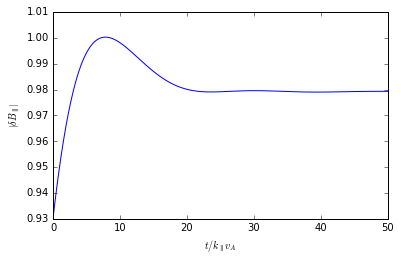

In [295]:
fig_bpar = plt.figure(figsize=[6, 6*0.618])
plt.plot(tbar_arr, bt_arr)
plt.xlabel('$t/k_\parallel v_{A}$')
plt.ylabel('$|\delta B_\parallel|$')

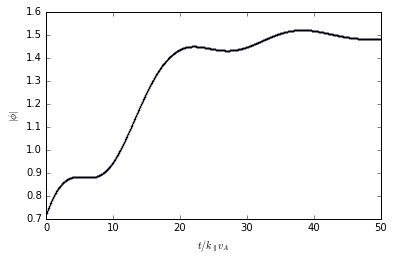

In [296]:
fig_phi = plt.figure(figsize=[6, 6*0.618])
plt.plot(tbar_arr, phi_arr, 'o')
plt.xlabel('$tk_\parallel v_{A}$')
plt.ylabel('$|\phi|$')

## compare with AstroGK simulation

In [299]:
data_dir = '/Volumes/yuguang_sd/data/agk/lin_response/lin_slow_1'
filename_bpar = data_dir + '/lin_slow_1.bpar'
filename_phi = data_dir + '/lin_slow_1.phi'

dtype_bpar = {'names': ('f1', 't', 'f2', 'bpar2', 'f3', 'f4', 'h1', 'h2'),
              'formats': ('S2', 'f4', 'S10', 'f4', 'S10', 'S10', 'f4', 'f4')}
dtype_phi = {'names': ('f1', 't', 'f2', 'phi2', 'f3', 'f4', 'h1', 'h2'),
              'formats': ('S2', 'f4', 'S10', 'f4', 'S10', 'S10', 'f4', 'f4')}
data_bpar = np.loadtxt(filename_bpar, dtype = dtype_bpar)
data_phi = np.loadtxt(filename_phi, dtype = dtype_phi)


bpar2 = np.array([elem[3] for elem in data_bpar])
bpar = np.sqrt(bpar2)
t_bpar = np.array([elem[1] for elem in data_bpar])

phi2 = np.array([elem[3] for elem in data_phi])
phi = np.sqrt(phi2)
t_phi = np.array([elem[1] for elem in data_phi])

(0, 5)

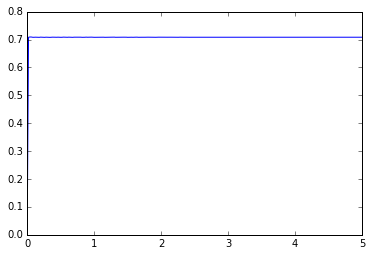

In [303]:
plt.plot(t_bpar, bpar)
plt.xlim(0, 5)

(0, 5)

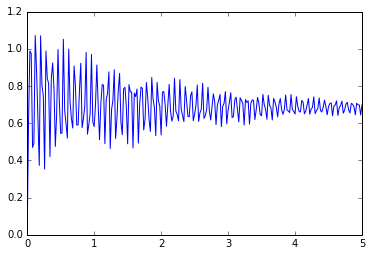

In [305]:
plt.plot(t_phi, phi)
plt.xlim([0, 5])